# Learning (Exponentially Tilted) Empirical Likelihoods from data

The Exponential Likelihood (EL) framework is a semi-parametric approach to statistical modeling that does not specift probability densities and thus make explicit noise assumptions. 

Instead, it poses certain moments $\mathbb{E}[g(X,\theta)] = 0$ to hold for the data distribution $X \sim F(\theta)$.

EL then builds a likelihood-analogue $l_e(\theta)$ from the empirical moments of $g(x_t, \theta)$, $,t=1,\ldots,T$ (note that we choose $t,T$ here as indices so we can reserve $n,N$ for multiple empirical datasets later -- we are not dealing with time series here, though EL extensions to time-series data exist).  
The approach here is of re-weighting the empirical distribution until the moments conditions $\mathbb{E}_w[g(x_t, \theta)] = 0$ hold, and to assign higher likelihoods to $\theta$ that require less reweighting.

Evaluating EL involves solving a constraint optimization problem for the weights $w_t, t=1,\ldots,T$. Hence learning the estimating equations $g(x, \theta)$ will invoke the implicit function theorem. 

This code aims to implement empirical likelihood and its variant exponentially tilted empirical likelihood (ETEL) and to test if learning the estimating equations via maximum EL (MEL, METEL) is feasible. One concern is that trivial constraints $\forall x, \theta : g(x,\theta)=0$ might be a problem since those will always yield the highest ELs, but in practice this is not much of a problem since there seems to be no gradiant towards this trivial solution.

One big issue in practice is the existence of solutions for $w_t \geq 0$, $\sum_t w_t=1$ satisfying $\mathbb{E}_w[g(x_t, \theta)] = 0$, which requires the origin to lie within the convex hull of the vectors $g(x_t,\theta), t=1\ldots,T$. There are extensions of EL that guarantee this (albeit at some cost in statistical efficiency), but which are not yet included in this code base. Ranges of possible $\theta$ are hence somewhat fiddly, and in many case ELs turn out to be zero, with correspondingly zero gradients wrt any estimating equation parameters.

The core idea of learning estimating equations and thus EL models via MEL however seems to hold !

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

dtype = torch.float64
dtype_np = np.float64
torch.set_default_dtype(dtype)

import etel
import el

from utils import toy_simulator as simulator
from utils import toy_setups, plot_res
from estimating_equations import EE_linear, EE_quadratic

g1D = toy_setups(setup='1D')
g2D = toy_setups(setup='2D')

### Empirical likelihood for the mean on 1D Gaussian data
Comparing an EL model with estimating equation for the mean, $g(x,\theta) = x - \theta$, against the Gaussian log-likelihood for the mean parameter $\mu$.
- Data is generated with true mean paramter $\mu =0.5$. Variance is held at $\sigma^2 = 1$, but could easily be changed.

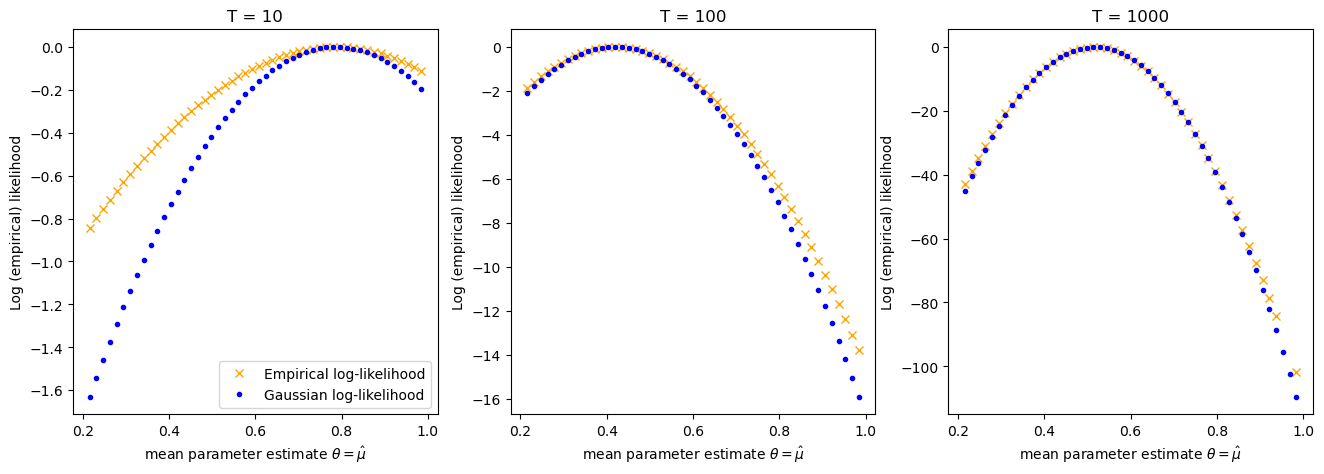

In [2]:
plot_res(g1D, simulator, log_pX𝜃=el.log_pX𝜃, 
         dtype=dtype, setup='1D', dist='gauss', 
         Ts=[10,100,1000], N=50, 𝜇=0.5, 𝜎=1.0)


### Exponentially tilted empirical likelihood for the mean on 1D Gaussian data
Comparing an ETEL model with estimating equation for the mean, $g(x,\theta) = x - \theta$, against the Gaussian log-likelihood.
- Data is generated with true mean paramter $\mu =0.5$. Variance is held at $\sigma^2 = 1$, but could easily be changed.

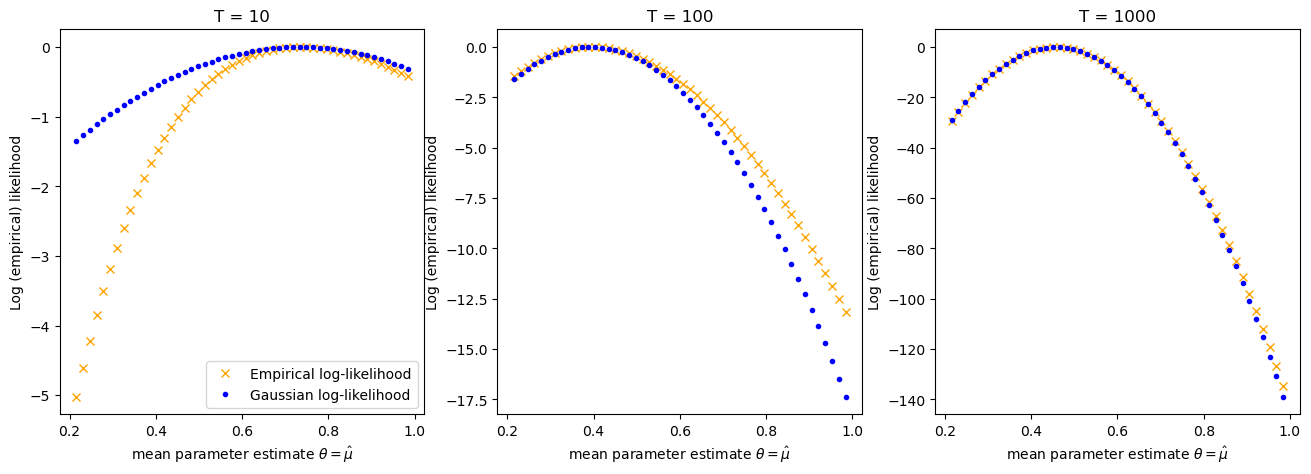

In [3]:
plot_res(g1D, simulator, log_pX𝜃=etel.log_pX𝜃, 
         dtype=dtype, setup='1D', dist='gauss', 
         Ts=[10,100,1000], N=50, 𝜇=0.5, 𝜎=1.0)

### Exponentially tilted empirical likelihood for the mean on 1D Gamma-distributed data
- Same exponential likelihood setup \& model, but we draw data from a Gamma distribution with mean $\mu=0.5$ and unit variance.
- The ETEL is now clearly asymmetric due to its semi-parametric nature, but still centered on $\mu=0.5$ for large enough sample sizes.
- Plotting the log-likelihood of the gamma distribution for comparison, but take that with a grain of salt since I'm reparametrizing the Gamma distribution written in scale and shape parameter in terms of mean and variance parameters, then plug in the ground-truth variance parameter, and plot the likelihood in the mean paramter. This could explain the apparent bias (maximum of likelihood around 0.4 instead of $\mu=0.5$) !

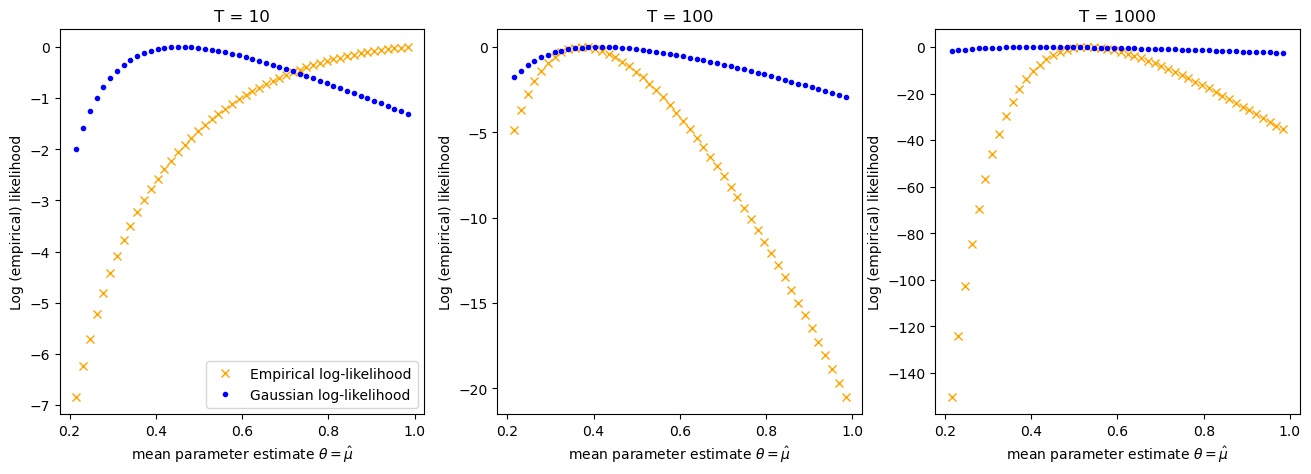

In [4]:
plot_res(g1D, simulator, log_pX𝜃=etel.log_pX𝜃, 
         dtype=dtype, setup='1D', dist='gamma', 
         Ts=[10,100,1000], N=50, 𝜇=0.5, 𝜎=1.0)

### Exponentially tilted empirical likelihood for mean and variance on 1D Gaussian data
- Instead of fixing $\sigma$, we estimate it from a second  (quadratic) estimating equation:
- $g_1(x, \theta) = x - \theta_1$
- $g_2(x, \theta) = x^2 - \theta_1^2 - \theta_2$

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


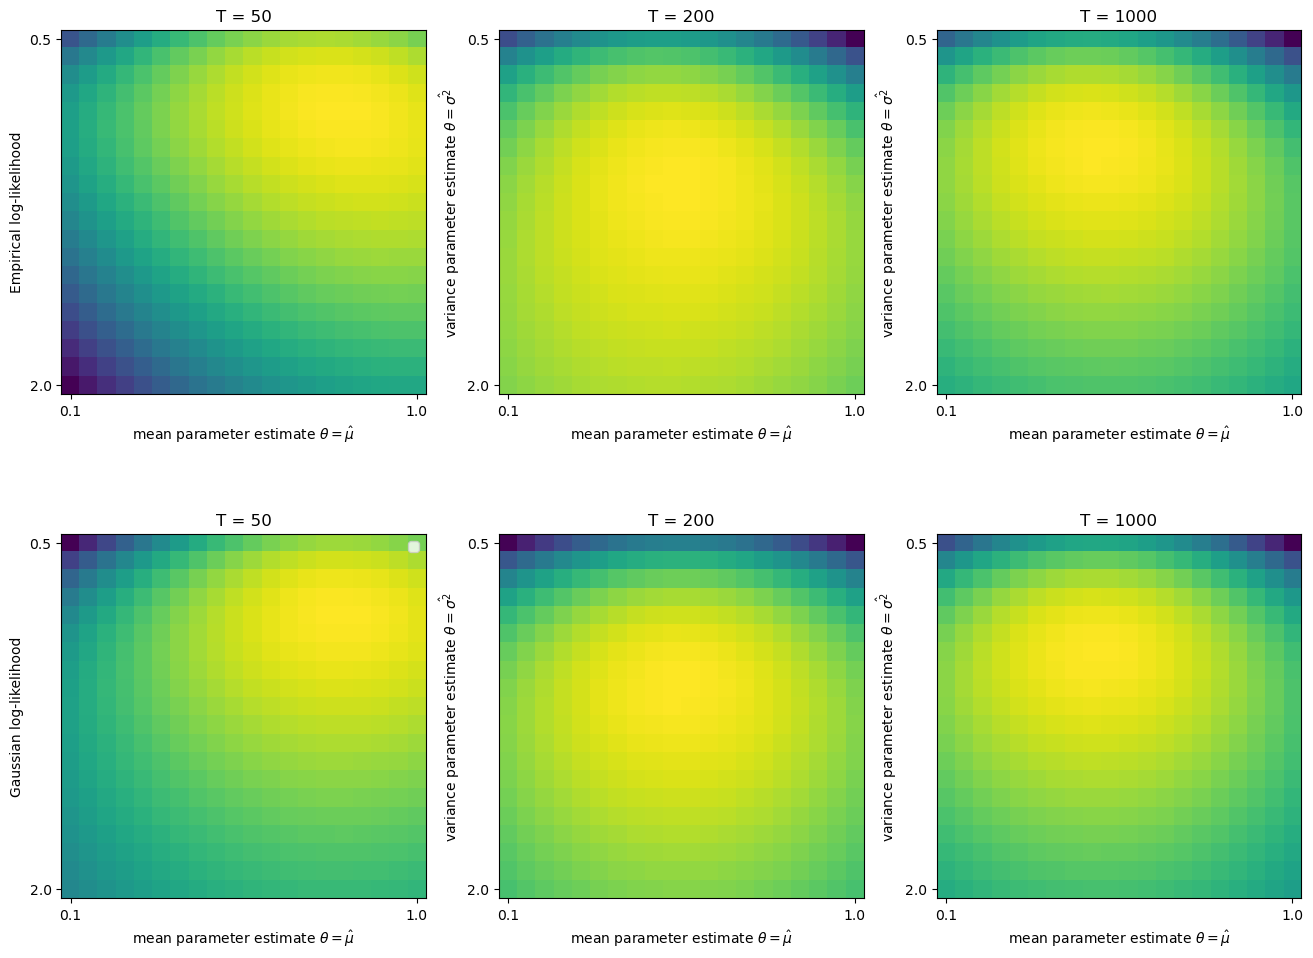

In [5]:
plot_res(g2D, simulator, log_pX𝜃=etel.log_pX𝜃, 
         dtype=dtype, setup='2D', dist='gauss', 
         Ts=[50,200,1000], N=20, 𝜇=0.5, 𝜎=1.0)

# Learning the estimating equations

### Perturb estimating equations for the mean
- We switch to $g(x, \theta) = x - 1.5 \theta - 0.3$, meaning that we estimate $\theta = 2/3 x - 0.2$
- Once more plot against Gaussian likelihood on toy data. 

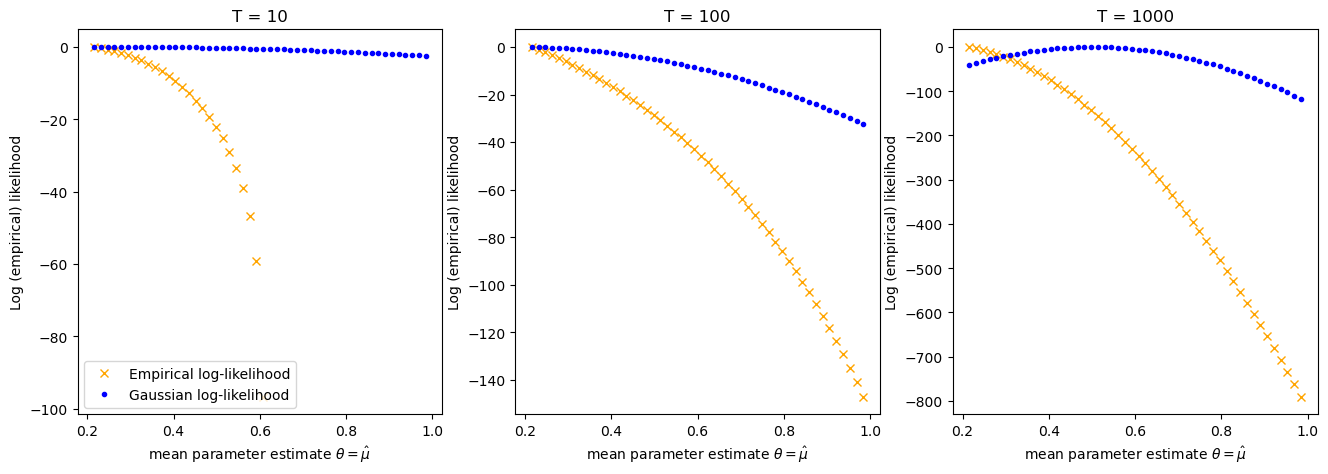

In [6]:
d = g1D.state_dict()
d['A'] = torch.tensor([[1.0,-1.5]])
d['c'] = torch.tensor([-0.3])
g1D.load_state_dict(d)

plot_res(g1D, simulator, log_pX𝜃=etel.log_pX𝜃, 
         dtype=dtype, setup='1D', dist='gauss', 
         Ts=[10,100,1000], N=50, 𝜇=0.5, 𝜎=1.0)

### Generate training dataset from Gaussian
- Sample $N$ datasets $\{x_t^{(n)}\}_{t=1}^T$ of iid draws $x_t^{(n)} \sim \mathcal{N}(\mu_n, \sigma^2)$ with different mean parameters $\mu_n, n = 1, \ldots, N$.
- This creates a dataset with $\langle x_t^{(n)} - \mu_n\rangle_t = 0$ for each $n$.
- We'll try to learn $g(x,\theta) = x - \theta$ from this data. 

In [7]:
N_train, T_train = 10, 1000
data_dist, setup = 'gauss', '1D'

𝜇s_train = np.random.randn(N_train) 
𝜎s_train = np.ones_like(𝜇s_train) #np.random.uniform(size=N_train) + 0.5
if data_dist == 'gamma':
    𝜇s_train = np.abs(𝜇s_train )

X_train = torch.tensor(simulator(T_train, 𝜇=𝜇s_train, 𝜎=𝜎s_train, dist=data_dist), dtype=dtype).unsqueeze(-1)
𝜇s_train = torch.tensor(𝜇s_train, dtype=dtype).unsqueeze(-1)

if setup == '1D':
    𝜃s_train = 𝜇s_train
elif setup == '2D':
    𝜎s_train = torch.tensor(𝜎s_train, dtype=dtype).unsqueeze(-1)
    𝜃s_train = torch.cat((𝜇s_train, 𝜎s_train),axis=-1)


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:26<00:00, 38.19it/s]


Text(0.5, 0, '# iter')

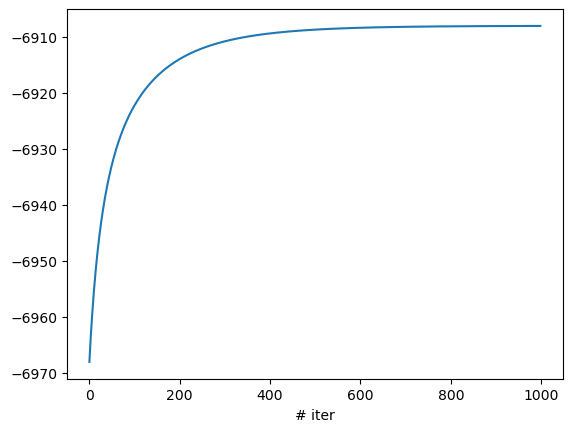

In [8]:
from etel import log_pX𝜃, grad_log_pX𝜃, grad_InfoNCE
import tqdm

n_steps = 1000
losses = np.zeros(n_steps)
g = g1D

if setup == '1D':
    lr = 1e-5
elif setup == '2D':
    lr = 5e-6
batch_size = 10

alg = 'MEL'
assert alg in ['NCE', 'MEL']

for i in tqdm.tqdm(range(n_steps)):
    idx = torch.tensor(np.random.choice(N_train, batch_size, replace=False))
    if alg == 'NCE':
        grad, losses[i] = grad_InfoNCE(g, X_train[idx], 𝜃s_train[idx])
    elif alg == 'MEL':
        losses[i] = log_pX𝜃(g, X_train[idx], 𝜃s_train[idx]).mean()
        grad = grad_log_pX𝜃(g, X_train[idx], 𝜃s_train[idx])
    d = g.state_dict()
    for p in d.keys():
        d[p] += lr * grad[p].mean(axis=0).reshape(*d[p].shape)
    g.load_state_dict(d)

import matplotlib.pyplot as plt

plt.plot(losses[:i])
plt.xlabel('# iter')

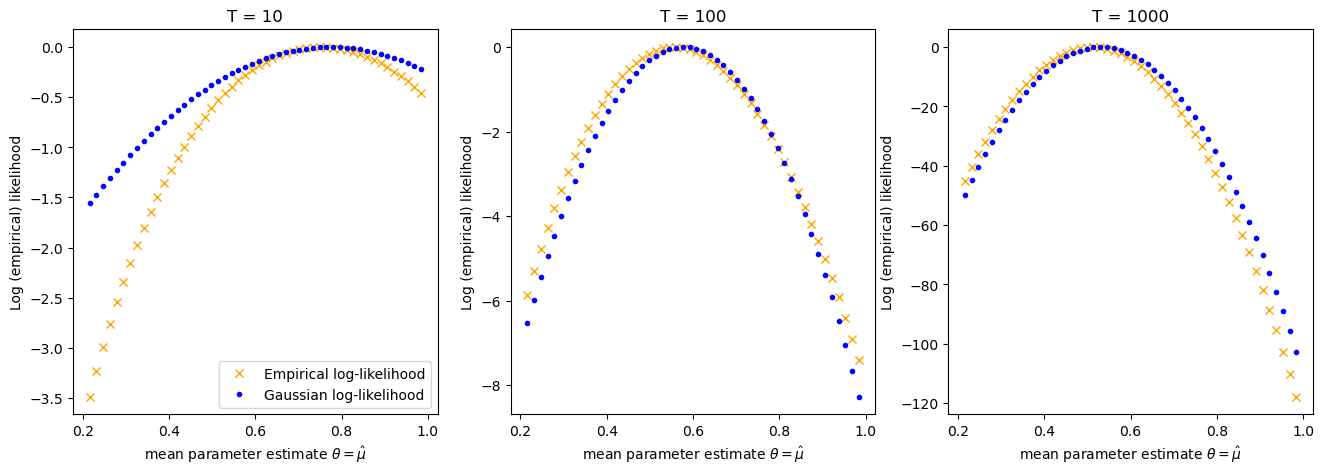

In [9]:
plot_res(g, simulator, log_pX𝜃=etel.log_pX𝜃, 
         dtype=dtype, setup='1D', dist='gauss', 
         Ts=[10,100,1000], N=50, 𝜇=0.5, 𝜎=1.0)

In [10]:
g.A

Parameter containing:
tensor([[ 1.2804, -1.3042]], requires_grad=True)

In [11]:
g.c

Parameter containing:
tensor([-0.0129], requires_grad=True)

## implement ETEL as PyTorch layer with registered forward- and backward pass
- main reason to write all of this in PyTorch in the first place !

In [ ]:
from torch.autograd.functional import jacobian

class Solver_𝜆(torch.autograd.Function):

    @staticmethod
    def forward(ctx, X, 𝜃):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        with torch.no_grad():
            G = g(X, 𝜃)
            dGd𝜙 = g.jacobian_pars(X, 𝜃)
            N, K = G.shape[0], G.shape[-1]
            𝜆0 = np.zeros((N, K))
            𝜆 = np.zeros_like(𝜆0)
            for i in range(N):
                def Φ_G(𝜆):
                    return Φ_np(𝜆, G[i].numpy())
                𝜆[i] = spo.minimize(Φ_G, 𝜆0[i])['x']
        ctx.save_for_backward(G, dGd𝜙, 𝜆)

        return torch.tensor(𝜆,dtype=dtype)

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.

        g(X,𝜃)             # N x T x K
        𝜆                  # N x     K
        w                  # N x T
        gradΦ(𝜆, G)        # N x     K
        dGd𝜙               # N x T x K x dim(𝜙)

        """
        G,dGd𝜙,𝜆 = ctx.saved_tensors
        with torch.no_grad():
            w = torch.exp(log_w_opt(𝜆, G))
            dΦd𝜆 = gradΦ(𝜆, G)
            dFd𝜆 = torch.bmm(G.transpose(-1,-2), G  * w.unsqueeze(-1)) - torch.bmm(dΦd𝜆.unsqueeze(-1), dΦd𝜆.unsqueeze(-2))

            #dwd𝜙 = w * torch.matmul(dGd𝜙 - torch.matmul(dGd𝜙, w).unsqueeze(-2), 𝜆) 
            #dFd𝜙 = torch.bmm(dgd𝜙, w) + torch.matmul(dwd𝜙, G)
            dFd𝜙 = torch.bmm((G  * w.unsqueeze(-1)).transpose(-1,-2), (dGd𝜙 * 𝜆.unsqueeze(-2).unsqueeze(-1)).sum(axis=-2)) 

            d𝜆d𝜙 = torch.linalg.solve(dFd𝜆, dFd𝜙) # Inverse function theorem: d𝜆d𝜙 = inv(dFd𝜆) * dFd𝜙 
        return grad_output * d𝜆d𝜙
